Um IDS Peak API zu nutzen: 

- ids_peak C://Programme/IDS/ids_peak/generic_api/binding/python/wheel/x86_64
- ids_peak_ipl C://Programme/IDS/ids_peak/generic_sdk/binding/python/wheel/x86_64
- in Explorer öffnen
- Rechtsklick irgendwo und PowerShell(Terminal ging auch) öffnen
- pip install und Dateinamen mit Erweiterung angeben

Code ist entsprechend lokal gespeichertem Beispiel Code (ca. obiger Pfad)

In [1]:
from ids_peak import ids_peak
from ids_peak import ids_peak_ipl_extension
import ids_peak_ipl.ids_peak_ipl
from ids_peak_ipl.ids_peak_ipl import Image, PixelFormatName_BGR8, ConversionMode_HighQuality,ConversionMode_Fast
import matplotlib.pyplot as plt
import cv2
import numpy as np

# presets
arucos = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
cam = 0

#setup ids_peak
ids_peak.Library.Initialize()
device_manager = ids_peak.DeviceManager.Instance()
print(device_manager)

<ids_peak.ids_peak.DeviceManager; proxy of <Swig Object of type 'peak::DeviceManager *' at 0x00000228384E7390> >


0: GV-580xSE-C (IDS GigE Vision @ "Ethernet" (D8-BB-C1-93-B8-45); IDS GenICam Producer (GEVK)v.1.11.0.1)
1: UI158xSE-C (IDS uEye; IDS GenICam Producer (uEye)v.1.11.0.1)
Model Name: GV-580xSE-C
User ID: 
Sensor Name: Sony IMX183CQJ-J
Exposure Time: 100163.41666666667
Digital Colorgain (Red):	1.5399999618530273
Digital Colorgain (Green):	1.0
Digital Colorgain (Blue):	2.130000114440918
Max. resolution (w x h): 5536 x 3692
PayLoadSize: 20093184
num buffers required: 3
Closing Device Manager
()
None
(array([[[5260., 1878.],
        [5458., 1905.],
        [5430., 2449.],
        [5223., 2421.]]], dtype=float32), array([[[1348., 1679.],
        [1398., 1683.],
        [1408., 1805.],
        [1353., 1793.]]], dtype=float32), array([[[2966., 1120.],
        [2993., 1123.],
        [2998., 1180.],
        [2965., 1176.]]], dtype=float32))


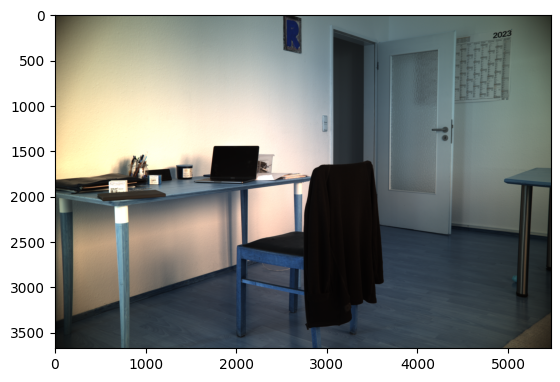

In [2]:
try: 
    device_manager.Update()
    if device_manager.Devices().empty():
        print("no devices found")
    else:
        for i, device in enumerate(device_manager.Devices()):
            print(str(i) + ": " + device.ModelName() + " ("
                  + device.ParentInterface().DisplayName() + "; "
                  + device.ParentInterface().ParentSystem().DisplayName() + "v."
                  + device.ParentInterface().ParentSystem().Version() + ")")
        # open first device
        device = device_manager.Devices()[cam].OpenDevice(ids_peak.DeviceAccessType_Control)

        # get the rmeote device node map
        nodemap_remote_device = device.RemoteDevice().NodeMaps()[0]
        # print model name and user ID
        print("Model Name: " + nodemap_remote_device.FindNode("DeviceModelName").Value())
        try:
            print("User ID: " + nodemap_remote_device.FindNode("DeviceUserID").Value())
        except ids_peak.Exception:
            print("User ID: (unknown)")
            
        # print sensor information, not knowing if device has the node "SensorName"
        try:
            print("Sensor Name: " + nodemap_remote_device.FindNode("SensorName").Value())
        except ids_peak.Exception:
            print("Sensor Name: " + "(unknown)")

        # set exposure time
        exposure_time_percentage = 0.05
        min_exposure_time = nodemap_remote_device.FindNode("ExposureTime").Minimum()
        max_exposure_time = nodemap_remote_device.FindNode("ExposureTime").Maximum()
        set_exposure_time = min_exposure_time + exposure_time_percentage*(max_exposure_time - min_exposure_time) if exposure_time_percentage <= 1 else max_exposure_time
        nodemap_remote_device.FindNode("ExposureTime").SetValue(set_exposure_time)
        print(f"Exposure Time: {set_exposure_time}")

        # set fps
        fps_percentage = 1
        min_frame_rate = nodemap_remote_device.FindNode("AcquisitionFrameRate").Minimum()
        max_frame_rate = nodemap_remote_device.FindNode("AcquisitionFrameRate").Maximum()
        set_frame_rate = min_frame_rate + fps_percentage*(max_frame_rate - min_frame_rate) if fps_percentage <= 1 else max_frame_rate
        nodemap_remote_device.FindNode("AcquisitionFrameRate").SetValue(set_frame_rate)

        # set color selector to red and set gain value
        nodemap_remote_device.FindNode("GainSelector").SetCurrentEntry("DigitalRed")
        nodemap_remote_device.FindNode("Gain").SetValue(1.54)
        print(f"Digital Colorgain (Red):\t{str(nodemap_remote_device.FindNode('Gain').Value())}")
        
        # set color selector to green and set gain value
        nodemap_remote_device.FindNode("GainSelector").SetCurrentEntry("DigitalGreen")
        nodemap_remote_device.FindNode("Gain").SetValue(1)
        print(f"Digital Colorgain (Green):\t{str(nodemap_remote_device.FindNode('Gain').Value())}")

        # set color selector to blue and set gain value
        nodemap_remote_device.FindNode("GainSelector").SetCurrentEntry("DigitalBlue")
        nodemap_remote_device.FindNode("Gain").SetValue(2.13)
        print(f"Digital Colorgain (Blue):\t{str(nodemap_remote_device.FindNode('Gain').Value())}")
        
        # print resolution
        try:
            print("Max. resolution (w x h): "
                  + str(nodemap_remote_device.FindNode("WidthMax").Value()) + " x "
                  + str(nodemap_remote_device.FindNode("HeightMax").Value()))
        except ids_peak.Exception:
            print("Max. resolution (w x h): (unknown)")
            
        dataStreams = device.DataStreams()
        if dataStreams.empty():
            print("dataStreams error ... not described which error") 
        dataStream = device.DataStreams()[0].OpenDataStream();
        nodemapDataStream = dataStream.NodeMaps()[0];
        try:
            if dataStream:
                # Flush queue and prepare all buffers for revoking
                dataStream.Flush(ids_peak.DataStreamFlushMode_DiscardAll)
                 
                # Clear all old buffers
                for buffer in dataStream.AnnouncedBuffers():
                   dataStream.RevokeBuffer(buffer)
                payload_size = nodemap_remote_device.FindNode("PayloadSize").Value()
                print(f"PayLoadSize: {payload_size}")
                # Get number of minimum required buffers
                num_buffers_min_required = dataStream.NumBuffersAnnouncedMinRequired()
                print(f"num buffers required: {num_buffers_min_required}")
                
                # Alloc buffers
                for count in range(num_buffers_min_required):
                    buffer = dataStream.AllocAndAnnounceBuffer(payload_size)
                    dataStream.QueueBuffer(buffer)
                
        except Exception as e:
            print(f"Exception while buffer allocating: {str(e)}")
        
        # start acquisition
        try:
            dataStream.StartAcquisition(ids_peak.AcquisitionStartMode_Default, ids_peak.DataStream.INFINITE_NUMBER)
            nodemap_remote_device.FindNode("TLParamsLocked").SetValue(1)
            nodemap_remote_device.FindNode("AcquisitionStart").Execute()
        except Exception as e:
            print(str(e))
        
        # receive image
        try: 
            buffer = dataStream.WaitForFinishedBuffer(5000)
            image = ids_peak_ipl_extension.BufferToImage(buffer)
            image = image.ConvertTo(PixelFormatName_BGR8, ConversionMode_Fast)
            dataStream.QueueBuffer(buffer)
        except Exception as e:
            print(str(e))
        # convert image to numpy array
        img = np.copy(image.get_numpy_3D())
        plt.imshow(img)
except Exception as e:
    print("Exception: " + str(e))
finally:
    print("Closing Device Manager")
    ids_peak.Library.Close()


(corners, ids, rejected) = cv2.aruco.detectMarkers(img, arucos,)
print(corners)
print(ids)
print(rejected)
img2 = cv2.aruco.drawDetectedMarkers(img, corners, ids)
plt.imshow(img)